### Downloading the data

In [133]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [134]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [135]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image_path_list = list(image_path.glob("*/*/*.jpg"))

def plot_random(path=image_path_list):
    random_image_path = random.choice(path)
    image_class = random_image_path.parent.stem
    img = Image.open(random_image_path)
    
    img_arr = np.array(img)
    plt.figure(figsize=(4,4))
    plt.imshow(img_arr)
    plt.title(f"Image class {image_class} \n Image shape {img_arr.shape}")
    plt.axis(False)

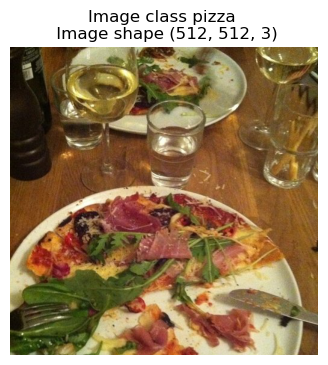

In [136]:
plot_random()

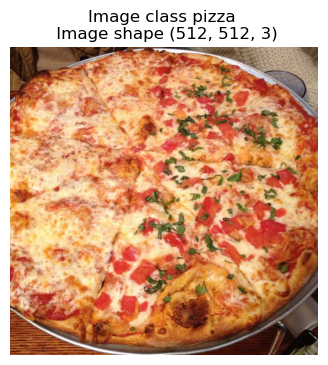

In [137]:
plot_random()

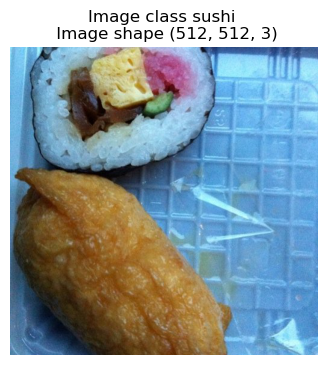

In [138]:
plot_random()

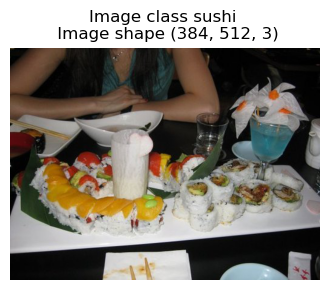

In [139]:
plot_random()

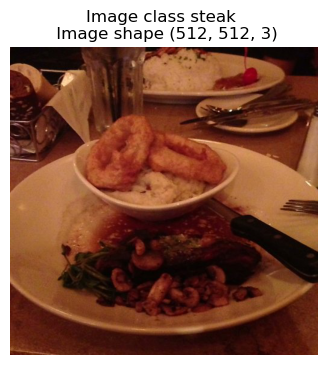

In [140]:
plot_random()

#### Transformations

In [141]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [142]:
# Write transform for image
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [143]:
def plot_transformations(image_paths,transform,n=6,seed=42):
    random.seed(seed)
    random_image_path = random.sample(image_paths,k=n)
    for image_path in random_image_path:
        image_class = image_path.parent.stem
        img = Image.open(image_path)
        img_arr = np.array(img)
        
        fig, ax = plt.subplots(1, 2)
        plt.figure(figsize=(4,4))
        ax[0].imshow(img_arr) 
        ax[0].set_title(f"Original \nSize: {img_arr.shape}")
        ax[0].axis("off")

        transformed_image = transform(img).permute(1,2,0)
        ax[1].imshow(transformed_image) 
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    

#### Data Sets and Data Loaders

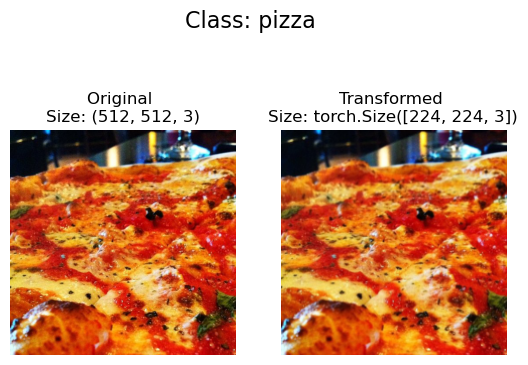

<Figure size 400x400 with 0 Axes>

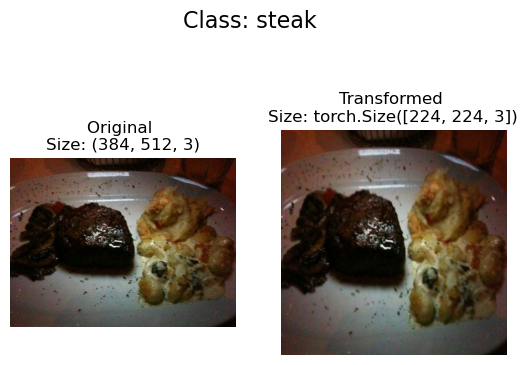

<Figure size 400x400 with 0 Axes>

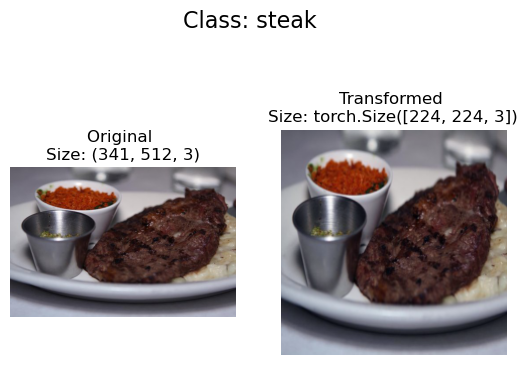

<Figure size 400x400 with 0 Axes>

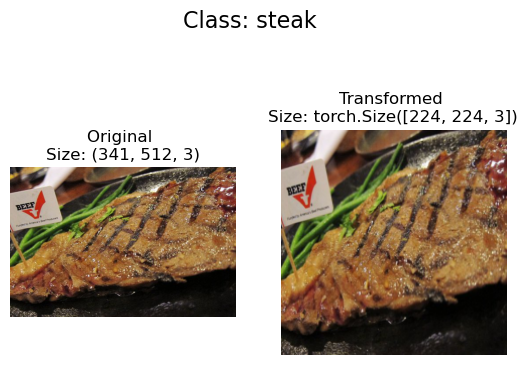

<Figure size 400x400 with 0 Axes>

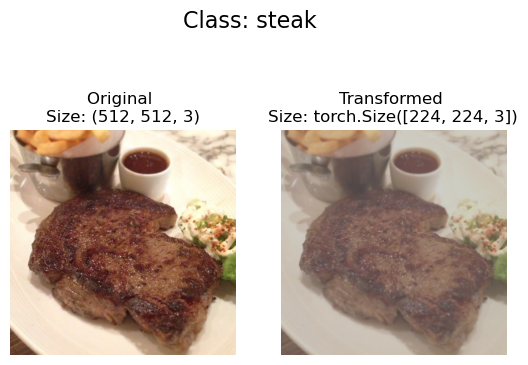

<Figure size 400x400 with 0 Axes>

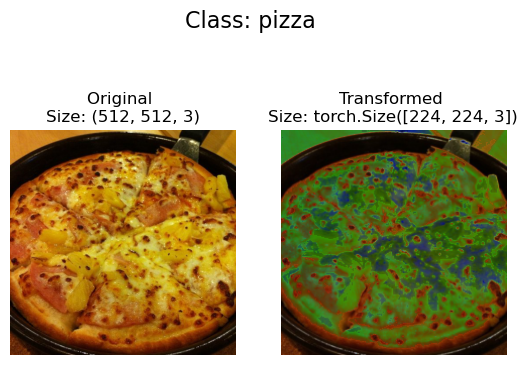

<Figure size 400x400 with 0 Axes>

In [144]:
plot_transformations(image_path_list,train_transform)

In [145]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [146]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [147]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1563b3bd0>,
 <torch.utils.data.dataloader.DataLoader at 0x156700510>)

### Simple model

In [160]:
import torch.nn as nn

class TinyVgg(nn.Module):
    def __init__(self, input_shape:int,hidden_units:16,output_shape:int)->None : 
        super().__init__()
        # conv block one
        self.convblock_one = nn.Sequential(
                nn.Conv2d(
                    in_channels = 3,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1
                ),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1
                ),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
        
        # conv block two
        self.convblock_two = nn.Sequential(
                nn.Conv2d(
                    in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1
                ),
                nn.ReLU(),
                nn.Conv2d(
                    in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1
                ),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
    
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 56 * 56, out_features = output_shape)
        )

    def forward(self,x:torch.Tensor):
        return self.classifier(self.convblock_two(self.convblock_one(x)))


In [161]:
torch.manual_seed(42)
model_zero = TinyVgg(input_shape=3,
                  hidden_units=16, 
                  output_shape=len(train_data.classes))
model_zero

TinyVgg(
  (convblock_one): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock_two): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=3, bias=True)
  )
)

In [154]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

Single image shape: torch.Size([1, 3, 224, 224])



In [163]:
# Model info
from torchinfo import summary
summary(model_zero, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVgg                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 16, 224, 224]         448
│    └─ReLU: 2-2                         [1, 16, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 16, 224, 224]         2,320
│    └─ReLU: 2-4                         [1, 16, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 16, 112, 112]         --
├─Sequential: 1-2                        [1, 16, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 16, 112, 112]         2,320
│    └─ReLU: 2-7                         [1, 16, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 16, 112, 112]         2,320
│    └─ReLU: 2-9                         [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 16, 56, 56]           --
├─Seq